This is an adaptation of [code by Dr. Jaume Manero. ](https://github.com/castorgit/weather_prediction/blob/main/Data_analysis_WeatherYHZ.ipynb).
<br>The dataset is a averaged resample meteorological data from 325 points around Kelowna, BC.
<br>The dataset [is available here](https://www.dropbox.com/s/50c83q80u5sn956/dly_avg_1of1_50.csv?dl=0).

In [32]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Since I am working in Google Colab the working directory needs to be set. The code below is a modification of [the directions found here](https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/).

In [33]:
import os 
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/FF/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

create_and_set_working_directory(project_folder)

In [34]:
#windrose is not installed be default in Colab
!pip install windrose

# Import libraries
import math 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from windrose import WindroseAxes


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GaussianNoise, Input, BatchNormalization, ELU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
#Import data
file = './data/dly_avg_1of1_50.csv'
df1 = pd.read_csv(file)

In [36]:
# we create a datetime index
df1['date'] = pd.to_datetime(df1['date'].astype(int), unit = 's')
df1 = df1.sort_values('date')
df1 = df1.reset_index(drop=True)

In [37]:
df2 = df1 [['date', 't2m']]
df2

,date,t2m
0,1980-04-01 00:00:00,274.366557
1,1980-04-01 01:00:00,275.053336
2,1980-04-01 02:00:00,274.536234
3,1980-04-01 03:00:00,270.578828
4,1980-04-01 04:00:00,270.836477
...,...,...
210569,2020-10-31 19:00:00,273.910372
210570,2020-10-31 20:00:00,276.520952
210571,2020-10-31 21:00:00,276.720903
210572,2020-10-31 22:00:00,275.592040


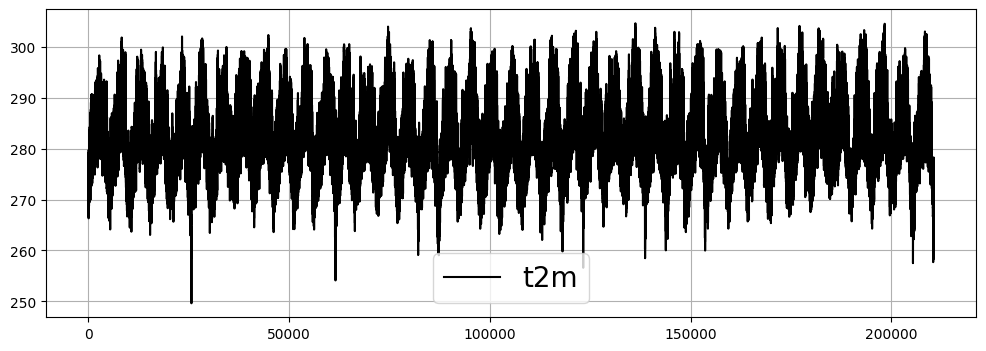

In [38]:
#Temperature plot
df2['t2m'].plot(figsize=(12,4), color='black');
plt.legend()
plt.grid()
plt.show()

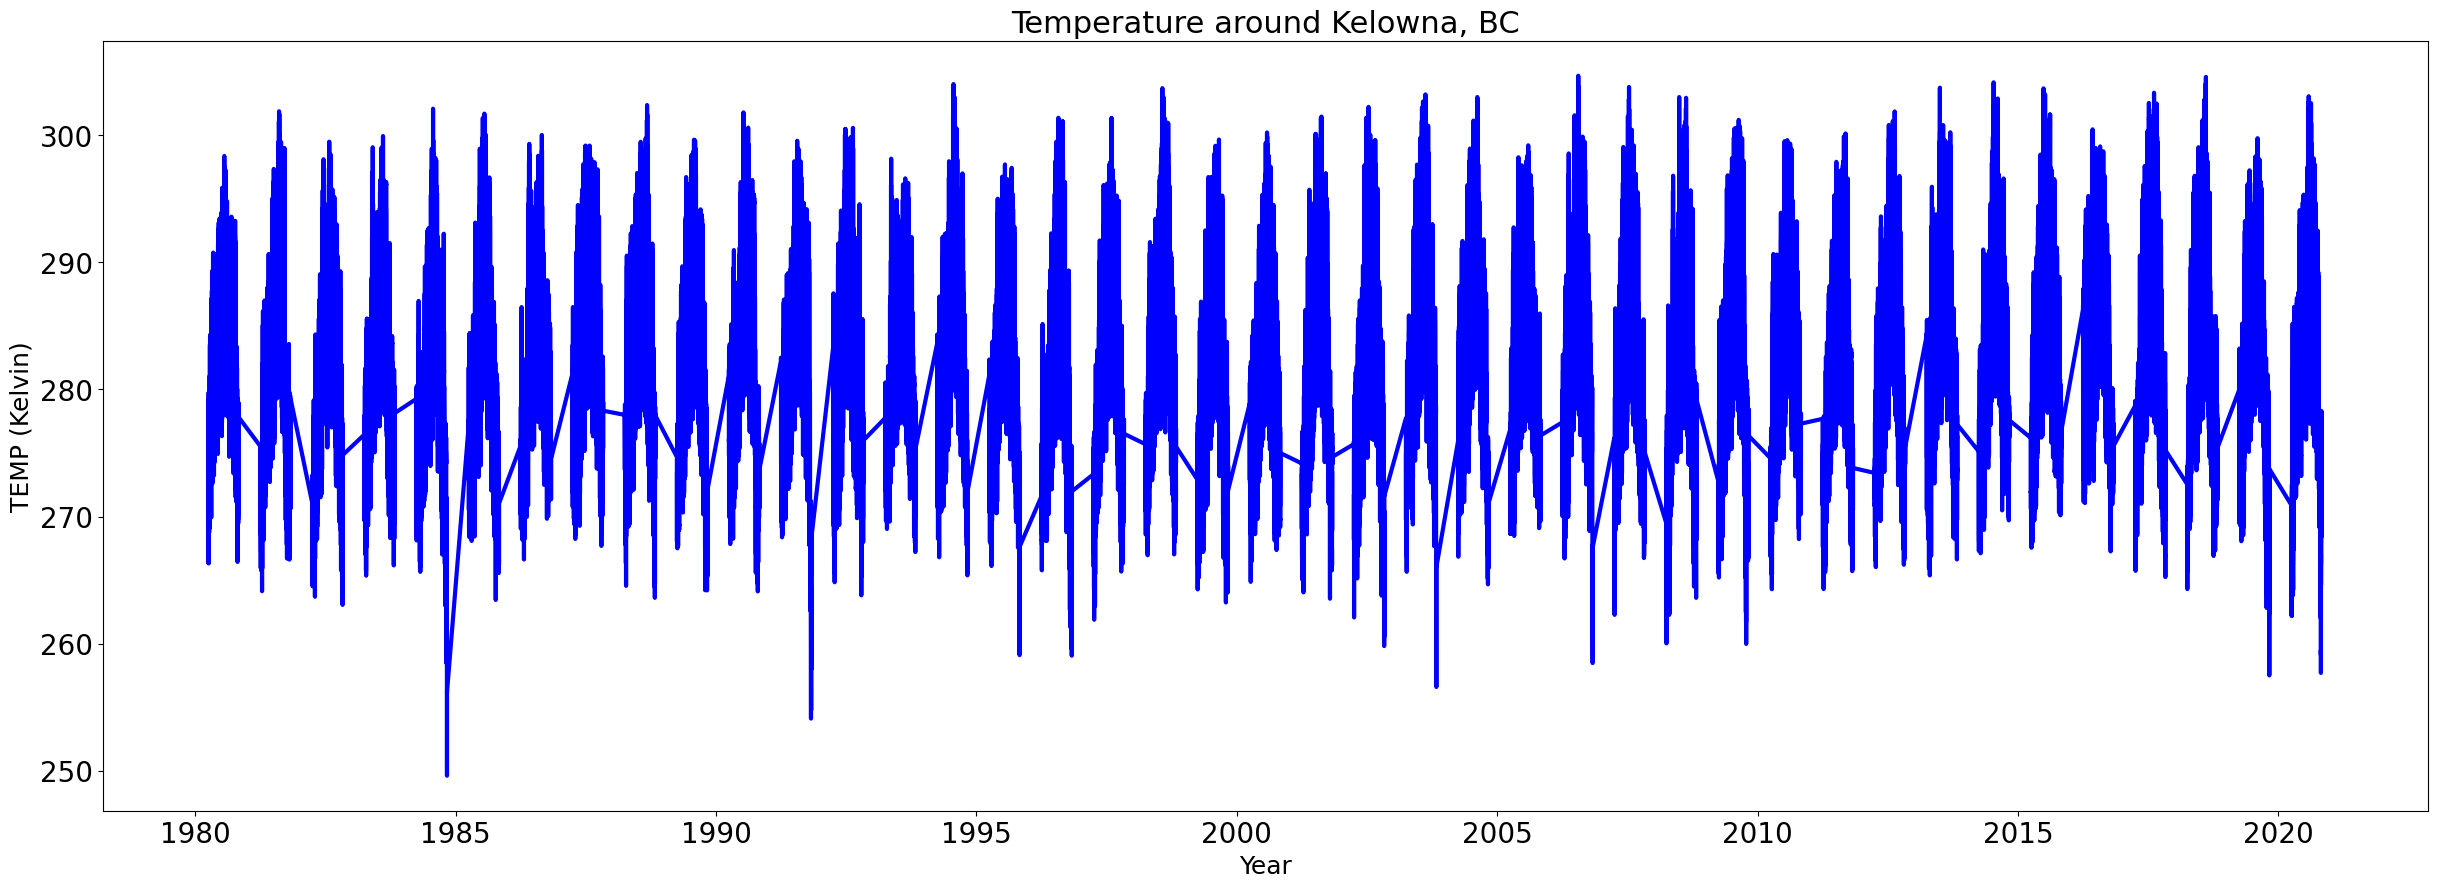

In [39]:
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df2['date'],df2['t2m'],color='blue',linewidth=3.0)
plt.title("Temperature around Kelowna, BC", size=22)
plt.ylabel("TEMP (Kelvin)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [40]:
# Downsample series to average temp per day
df_day_grouped = df2.set_index('date').groupby(pd.Grouper(freq='d')).agg({'t2m': ['mean', 'min', 'max']})
df_day_grouped = df_day_grouped.reset_index()
df_day_grouped.columns = df_day_grouped.columns.map(''.join)
df_day_grouped

,date,t2mmean,t2mmin,t2mmax
0,1980-04-01,271.493059,266.950614,276.791270
1,1980-04-02,271.542494,266.701522,278.132063
2,1980-04-03,272.212766,266.322560,278.710778
3,1980-04-04,273.670045,268.457058,279.767512
4,1980-04-05,274.301922,270.488384,278.889608
...,...,...,...,...
14819,2020-10-27,270.511909,268.478572,275.155169
14820,2020-10-28,273.877920,273.108847,275.121031
14821,2020-10-29,276.009298,274.897392,278.300788
14822,2020-10-30,276.396830,274.797808,278.056967


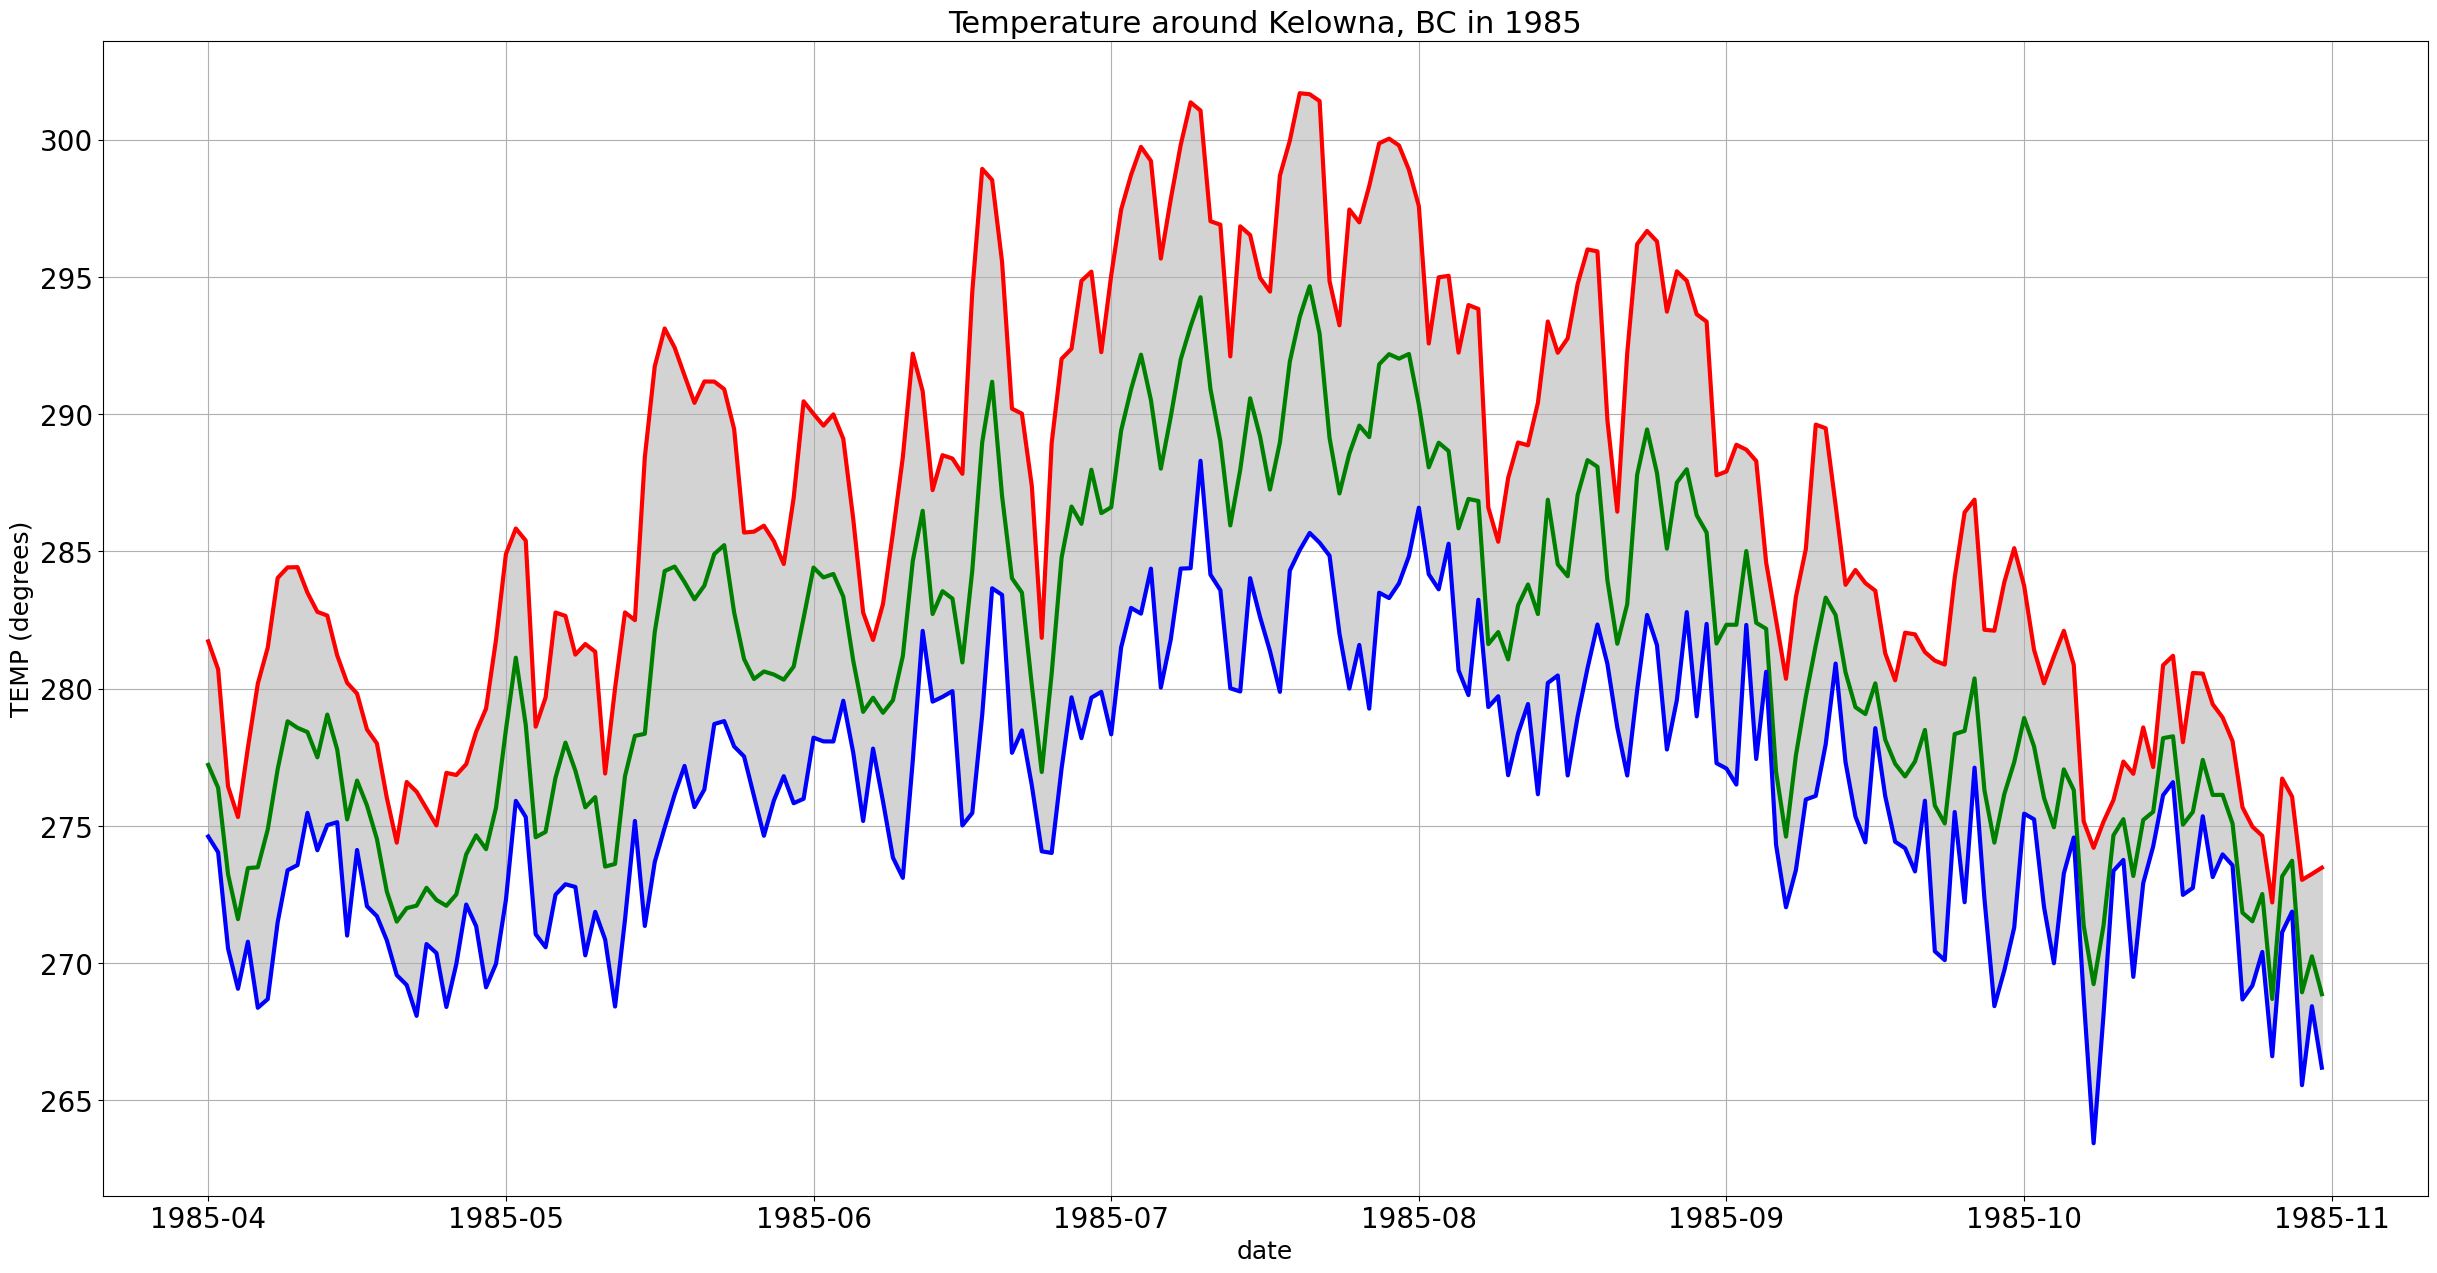

In [41]:
# More sophisticated plot
# Let's do it only for one year y
y = 1985

df_temps = df_day_grouped[df_day_grouped['date'].dt.year == y ]
fig, ax = plt.subplots(figsize=(30,15))

ax.plot(df_temps['date'],df_temps['t2mmean'],color='green',linewidth=3.0)
ax.plot(df_temps['date'],df_temps['t2mmax'],color='red',linewidth=3.0)
ax.plot(df_temps['date'],df_temps['t2mmin'],color='blue',linewidth=3.0)
ax.fill_between(df_temps['date'],df_temps['t2mmin'], df_temps['t2mmax'], color='lightgrey')
                                                                                 
#ax.scatter(df2['date'],df2['births'],color='red',s=100.)
plt.title("Temperature around Kelowna, BC in "+str(y), size=22)
plt.ylabel("TEMP (degrees)", size=18)
plt.xlabel("date", size=18)
plt.grid(axis='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [42]:
df3 = df1 [['date', 'u10', 'v10']]
df3

,date,u10,v10
0,1980-04-01 00:00:00,0.440549,-1.445691
1,1980-04-01 01:00:00,0.731630,-1.316768
2,1980-04-01 02:00:00,0.961352,-1.170466
3,1980-04-01 03:00:00,0.890988,-1.106444
4,1980-04-01 04:00:00,0.818286,-1.056283
...,...,...,...
210569,2020-10-31 19:00:00,0.007458,0.856491
210570,2020-10-31 20:00:00,0.134878,1.052256
210571,2020-10-31 21:00:00,0.310939,1.017918
210572,2020-10-31 22:00:00,0.144146,0.876481


In [43]:
wind_speed = np.sqrt((pow(df3['u10'],2) + pow(df3['v10'],2)))
wind_speed

0         1.511326
1         1.506373
2         1.514658
3         1.420591
4         1.336161
            ...   
210569    0.856523
210570    1.060865
210571    1.064350
210572    0.888255
210573    0.873812
Length: 210574, dtype: float64

In [44]:
wind_direction = np.arctan2(df3['v10'], df3['u10']) * 180 / np.pi
wind_direction

0        -73.052320
1        -60.942318
2        -50.602315
3        -51.156502
4        -52.235616
            ...    
210569    89.501101
210570    82.695668
210571    73.013870
210572    80.660765
210573    77.432015
Length: 210574, dtype: float64

[]

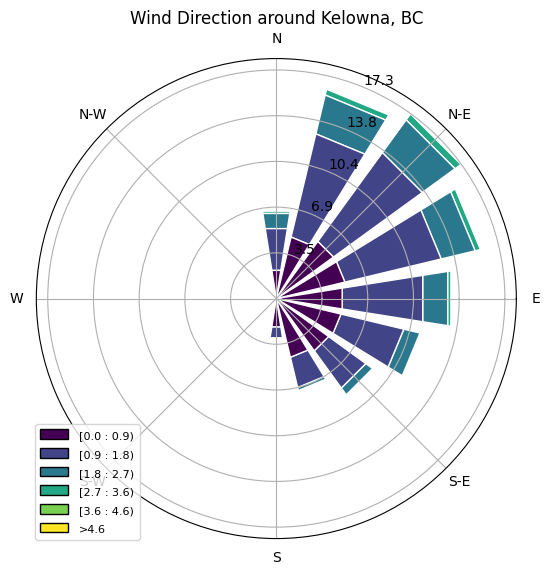

In [45]:
# fix degrees and this will work
# Windrose to analyze wind direction
# Windrose to see the wind direction in a better visualization
# I believe wind direction is in degrees starting 0 to 360. Angles rounded to 10
# where is the 0? Hyphotesis E = 0 and works anticlockwise

vientospeed     = wind_speed
vientodirection = wind_direction
title = 'Wind Direction around Kelowna, BC'

plt.rc('legend', fontsize=10)

f = plt.figure(figsize=(12,6))

ax = WindroseAxes.from_ax(fig=f)
ax.bar(vientodirection, vientospeed, normed=True, opening=0.8, edgecolor='white')
ax.set_title(title)
ax.set_legend()
ax.plot()

In [46]:
columns = list(df1)
columns

['Unnamed: 0',
 'date',
 'u10',
 'v10',
 'd2m',
 't2m',
 'e',
 'chv',
 'cvl',
 'skt',
 'stl1',
 'stl2',
 'stl3',
 'stl4',
 'slt',
 'sp',
 'tp',
 'swvl1',
 'swvl2',
 'swvl3',
 'swvl4',
 'month',
 'day',
 'hour',
 'year',
 'doy',
 'ignition']

In [47]:
lag = 12
df1.columns
cols = columns

drop_cols = ['Unnamed: 0','chv','cvl','month', 'day', 'hour', 'year', 'doy', 'ignition']

ts_multivar = df1.drop(drop_cols, axis=1)

<Figure size 2000x1000 with 0 Axes>

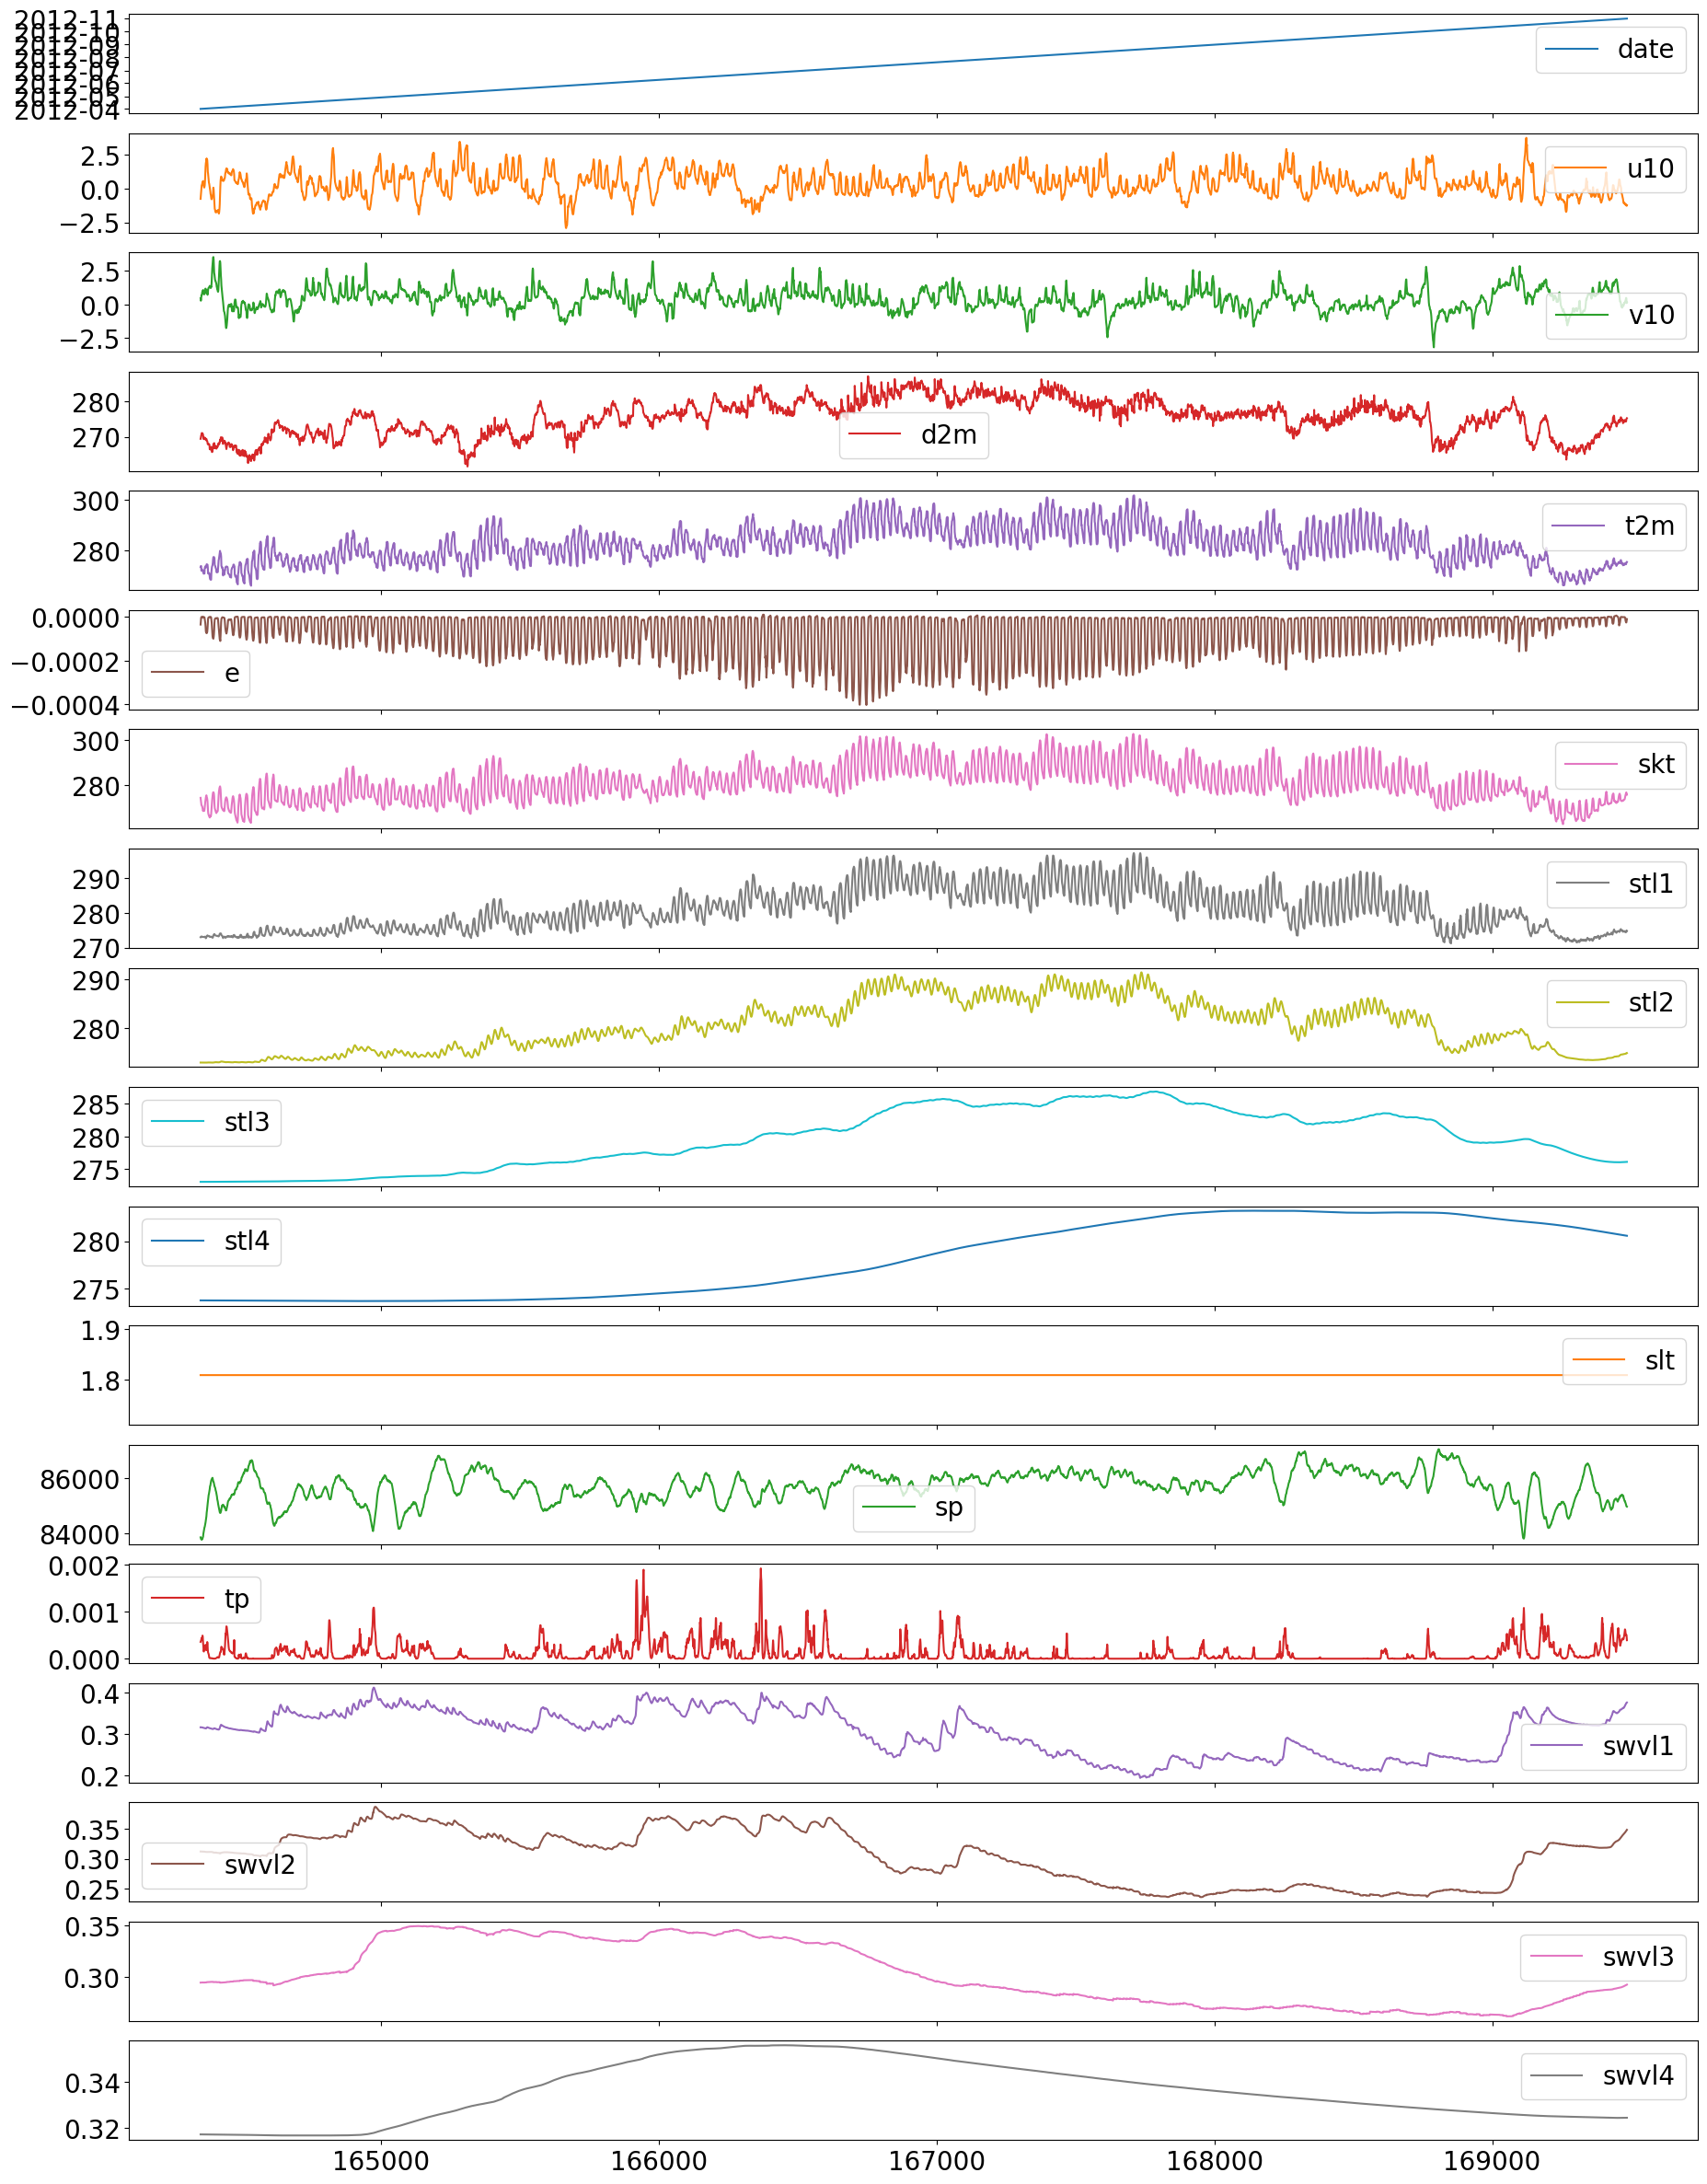

In [48]:
from_date = "2012-04-01 00:00:00"
to_date   = "2012-10-31 23:00:00"

df = ts_multivar[ts_multivar['date'].dt.year == 2012 ]

plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=20)
df.plot(subplots=True, legend=True, figsize=(22,30), use_index=True, fontsize=20)
plt.show()

In [49]:
ts_multivar.isna().sum().sum()
ts_multivar = ts_multivar.dropna()

In [50]:
ts_multivar = ts_multivar.drop('date', axis=1)
weather_data = ts_multivar.to_numpy()
weather_data.shape

(210574, 17)

In [51]:
# Examples dataframe creation
#print('Input dataframe structure', ts_multivar.shape)

# create train, test, val (80%, 10%, 10%)
train_split = 0.8
test_split = 0.1

lag = 30
ahead = 12

datasize =  weather_data.shape[0]
trainsize = int(datasize * train_split)
half_test = int(datasize * test_split)
testsize = int(half_test*2)

sc=StandardScaler()
tmpdata = sc.fit_transform(weather_data)
Scaler = sc.fit(weather_data[:, 0].reshape(-1,1))  # saves the scaler for the first variable for descaling
#Scaler = sc.fit(weather_data[:, 0])  # saves the scaler for the first variable for descaling
weather_data = tmpdata

In [52]:
weather_data.shape

(210574, 17)

In [53]:
weather_data[:, 0].reshape(1,-1).shape

(1, 210574)

In [54]:
t_s_multivariate = weather_data

def lag_matrix(wind_train, lag=lag, ahead=ahead):
    wind_train = data[:trainsize, :]
    lvect = []
    for i in range(lag + ahead):
       lvect.append(data[i: -lag - ahead + i, :])
    return(np.stack(lvect, axis=1))

# data = train -> test -> val

data = t_s_multivariate[:trainsize, :]

train = lag_matrix(data, lag, ahead)

train_x = train[:, :lag]
train_x = np.swapaxes(train_x, 1, 2)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1] * train_x.shape[2]))

data  = t_s_multivariate[trainsize:trainsize + testsize, :]

test  = lag_matrix(data, lag, ahead)
half_test = int(test.shape[0] / 2)

test_x = test[:half_test, :lag]
val_x = test[half_test:, :lag]

train_y = train[:, -12:, 0]
test_y   = test[:half_test, -12:, 0]
val_y  = test[half_test:, -12:, 0]


test_x = np.swapaxes(test_x, 1, 2)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1] * test_x.shape[2]))
val_x = np.swapaxes(val_x, 1, 2)
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1] * val_x.shape[2]))


print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("shape x_val      : ", val_x.shape,  " y_val       : ", val_y.shape)
print("=============================================================")

input_dimensions = train_x.shape[1:]
print(input_dimensions)

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (168417, 510)  y_training: :  (168417, 12)
shape x_test     :  (21036, 510)  y_test      :  (21036, 12)
shape x_val      :  (21036, 510)  y_val       :  (21036, 12)
(510,)


In [55]:
data_input = Input(shape=input_dimensions)
layer = Dense(1024)(data_input)
layer = ELU(alpha=0.3)(layer)
layer = Dropout(rate=0.3)(layer)
layer = Dense(512, activation= 'elu')(layer)
layer = Dropout(rate=0.3)(layer)
layer = Dense(512, activation= 'elu')(layer)
layer = Dropout(rate=0.3)(layer)
output = Dense(12, activation='linear')(layer)

MLP = Model(inputs=data_input, outputs=output, name='MLP')
MLP.summary()

opt = Adam(0.0001, clipnorm=1.)
MLP.compile(loss='mean_squared_error',optimizer=opt, )

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 510)]             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              523264    
                                                                 
 elu_1 (ELU)                 (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656  

In [56]:
batch_size = 512
nepochs = 200
early = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

MLP.fit(train_x, train_y, batch_size=batch_size, epochs=nepochs, validation_data=(test_x, test_y), 
         verbose=True, callbacks=[early])
#, callbacks=cbacks

Epoch 1/200
329/329 [==============================] - 4s 6ms/step - loss: 0.4887 - val_loss: 0.2284
Epoch 2/200
329/329 [==============================] - 2s 5ms/step - loss: 0.2885 - val_loss: 0.2102
Epoch 3/200
329/329 [==============================] - 3s 8ms/step - loss: 0.2563 - val_loss: 0.2072
Epoch 4/200
329/329 [==============================] - 3s 9ms/step - loss: 0.2401 - val_loss: 0.1956
Epoch 5/200
329/329 [==============================] - 4s 11ms/step - loss: 0.2296 - val_loss: 0.1951
Epoch 6/200
329/329 [==============================] - 3s 9ms/step - loss: 0.2214 - val_loss: 0.1882
Epoch 7/200
329/329 [==============================] - 3s 8ms/step - loss: 0.2155 - val_loss: 0.1899
Epoch 8/200
329/329 [==============================] - 3s 8ms/step - loss: 0.2108 - val_loss: 0.1835
Epoch 9/200
329/329 [==============================] - 3s 10ms/step - loss: 0.2064 - val_loss: 0.1798
Epoch 10/200
329/329 [==============================] - 4s 11ms/step - loss: 0.2026 - val

In [57]:
# Perform predictions

val_yp = MLP.predict(val_x, batch_size=batch_size, verbose=0)
test_yp = MLP.predict(test_x, batch_size=batch_size, verbose=0)

In [58]:
# Evaluating results

lresults = []
val_y_R2 = []
test_y_R2 = []
acum_val, acum_test = 0,0
for i in range (1,12+1):
   v_yp = Scaler.inverse_transform(val_yp[:, i - 1].reshape(-1,1))
   v_y = Scaler.inverse_transform(val_y[:, i - 1].reshape(-1,1))
   t_yp = Scaler.inverse_transform(test_yp[:, i - 1].reshape(-1,1))
   t_y = Scaler.inverse_transform(test_y[:, i - 1].reshape(-1,1))
   val_y_R2.append(r2_score(v_yp,v_y))
   test_y_R2.append(r2_score(t_yp, t_y))
   
print ("Results === Test == Validation ")
print('=============================')
for i in range (0,12):
   print('step', "{:<4d}".format(i+1), '- ', "{:.3f}".format(val_y_R2[i]), "   {:.3f}".format(test_y_R2[i]))          
   acum_val = acum_val + val_y_R2[i]
   acum_test = acum_test + test_y_R2[i]
print('=============================')
print('Summary', '  - ', "{:.3f}".format(acum_val), "   {:.3f}".format(acum_test))

Results === Test == Validation 
step 1    -  0.985    0.984
step 2    -  0.964    0.963
step 3    -  0.937    0.936
step 4    -  0.904    0.904
step 5    -  0.862    0.865
step 6    -  0.813    0.820
step 7    -  0.757    0.769
step 8    -  0.694    0.710
step 9    -  0.626    0.645
step 10   -  0.556    0.578
step 11   -  0.486    0.513
step 12   -  0.415    0.447
Summary   -  8.998    9.135


In [60]:
#this doesn't work in Colab
#import session_info
#session_info.show(html=False)

In [61]:
#EOF